# IONEX

Utilities and examples to deal with IONEX files in Python

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
import cartopy.crs as ccrs
import wget
import subprocess

# Larger figure size
fig_size = [14, 10]
plt.rcParams['figure.figsize'] = fig_size

Utility functions to dowload IONEX files, get TEC and plot TEC maps. See below for examples of use.

In [2]:
def parse_map(tecmap, exponent = -1):
    tecmap = re.split('.*END OF TEC MAP', tecmap)[0]
    return np.stack([np.fromstring(l, sep=' ') for l in re.split('.*LAT/LON1/LON2/DLON/H\\n',tecmap)[1:]])*10**exponent
    
def get_tecmaps(filename):
    with open(filename) as f:
        ionex = f.read()
        return [parse_map(t) for t in ionex.split('START OF TEC MAP')[1:]]

def get_tec(tecmap, lat, lon):
    i = round((87.5 - lat)*(tecmap.shape[0]-1)/(2*87.5))
    j = round((180 + lon)*(tecmap.shape[1]-1)/360)
    return tecmap[i,j]

def ionex_filename(year, day, centre, zipped = True):
    return '{}g{:03d}0.{:02d}i{}'.format(centre, day, year % 100, '.Z' if zipped else '')

def ionex_ftp_path(year, day, centre):
    return 'ftp://cddis.gsfc.nasa.gov/gnss/products/ionex/{:04d}/{:03d}/{}'.format(year, day, ionex_filename(year, day, centre))

def ionex_local_path(year, day, centre = 'esa', directory = '/tmp', zipped = False):
    return directory + '/' + ionex_filename(year, day, centre, zipped)
    
def download_ionex(year, day, centre = 'esa', output_dir = '/tmp'):
    wget.download(ionex_ftp_path(year, day, centre), output_dir)
    subprocess.call(['gzip', '-d', ionex_local_path(year, day, centre, output_dir, zipped = True)])
    
def plot_tec_map(tecmap):
    proj = ccrs.PlateCarree()
    f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj))
    ax.coastlines()
    h = plt.imshow(tecmap, cmap='viridis', vmin=0, vmax=100, extent = (-180, 180, -87.5, 87.5), transform=proj)
    plt.title('VTEC map')
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    f.add_axes(ax_cb)
    cb = plt.colorbar(h, cax=ax_cb)
    plt.rc('text', usetex=True)
    cb.set_label('TECU ($10^{16} \\mathrm{el}/\\mathrm{m}^2$)')

This downloads all the daily IONEX files for the year 2017.

This takes a while to run, since it downloads one file at a time.

In [3]:
for day in range(1, 366):
    download_ionex(2017, day)

**Example 1**

Plot all the TEC maps for a given day.

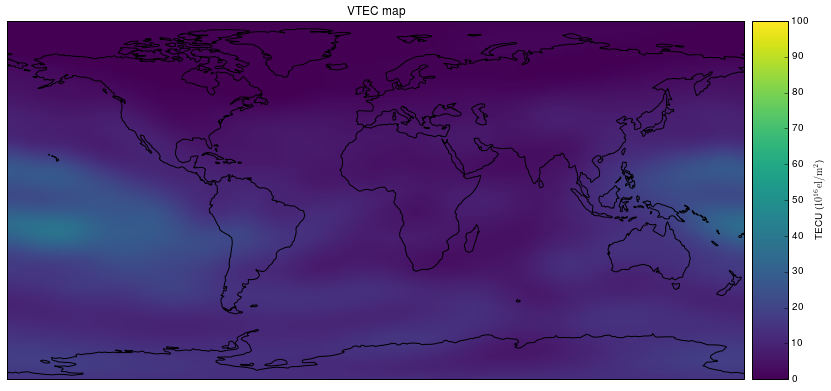

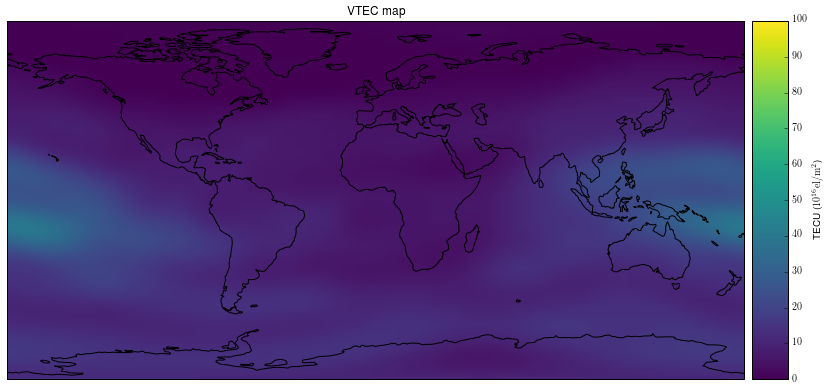

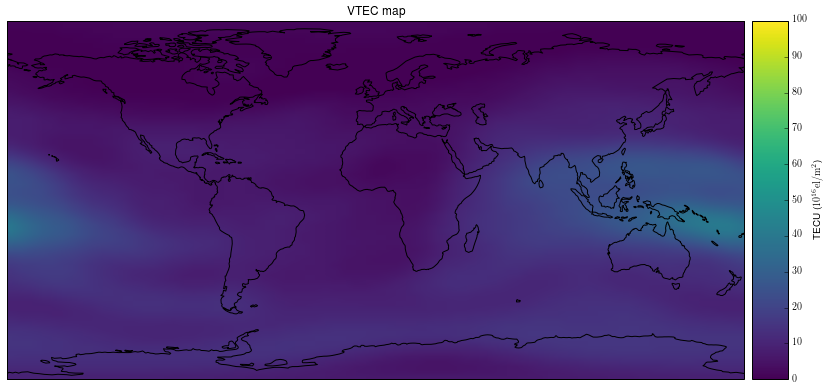

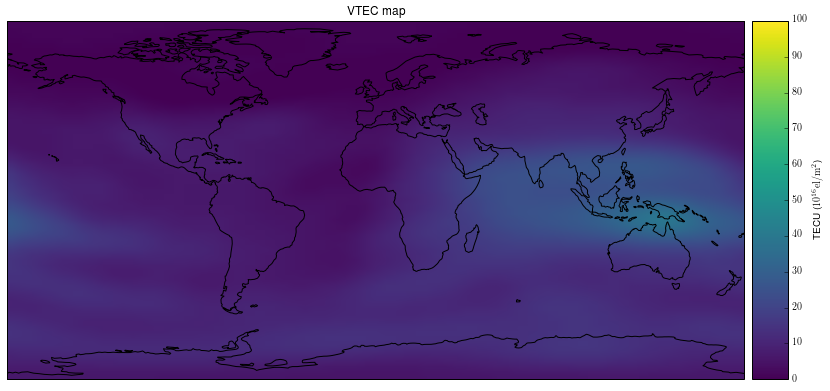

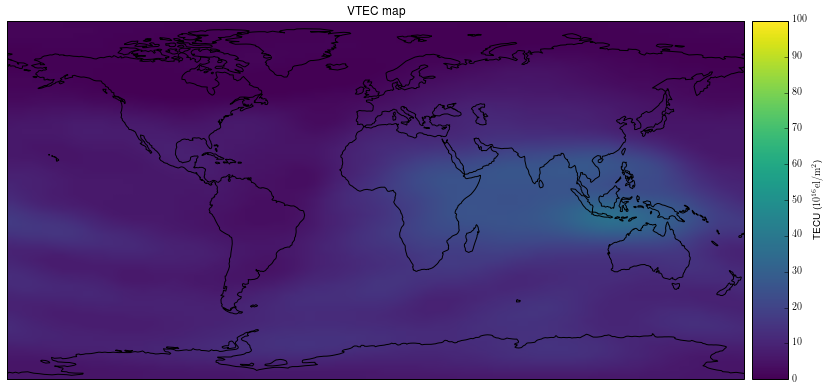

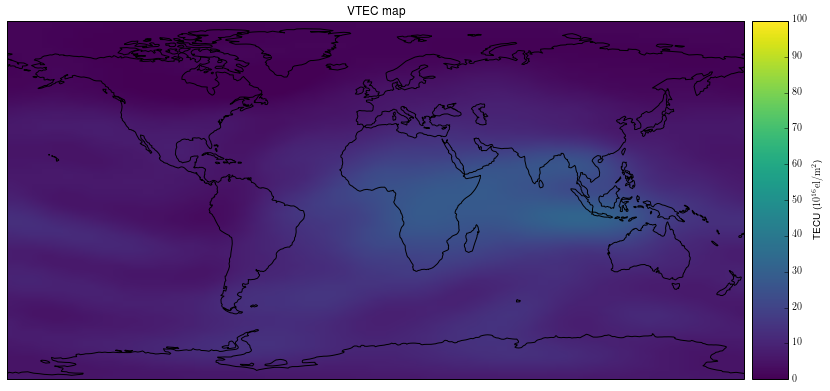

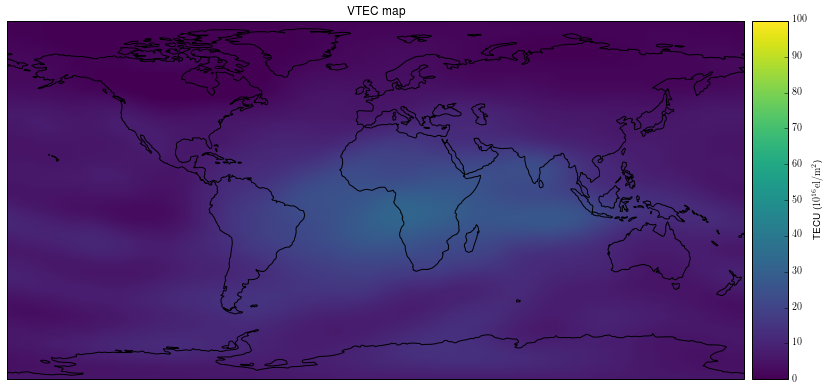

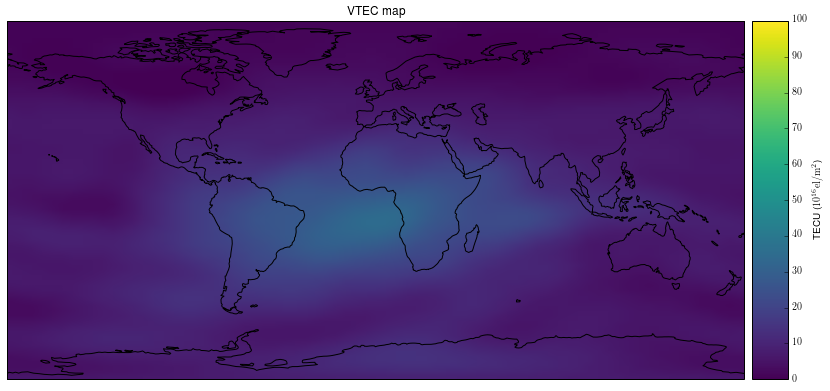

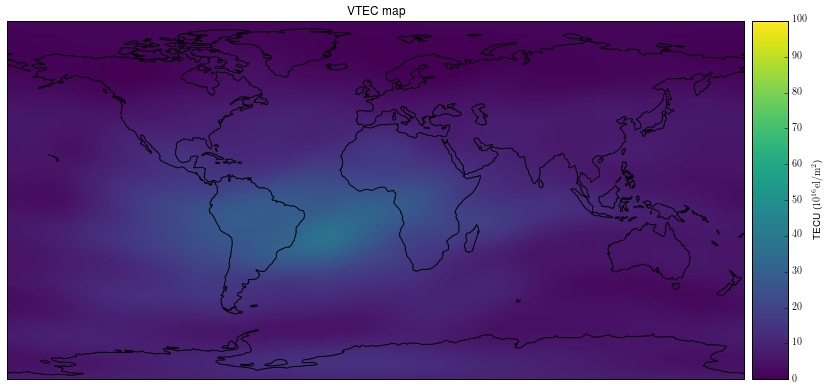

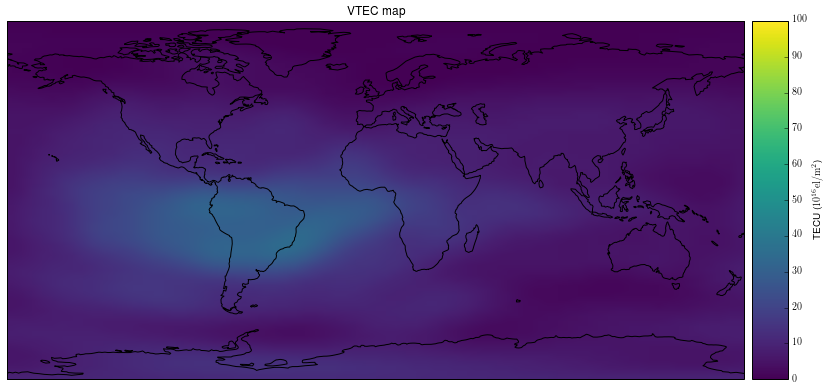

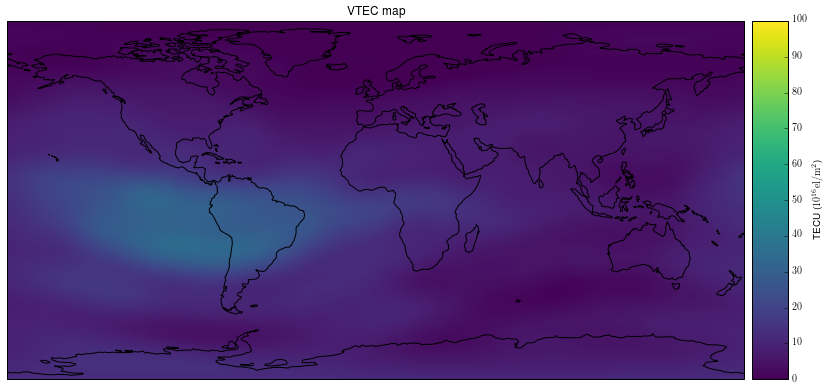

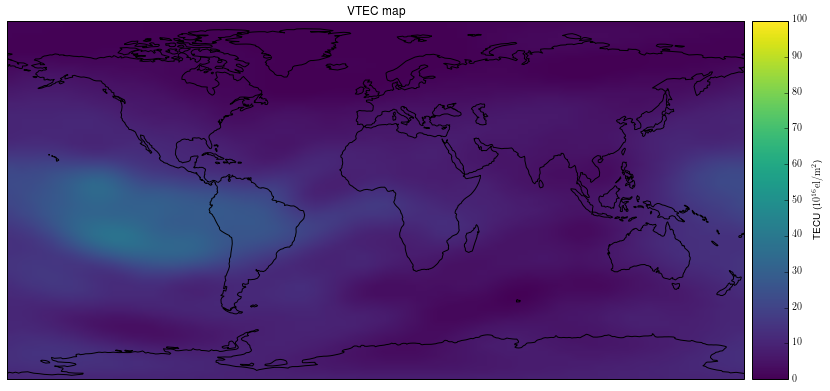

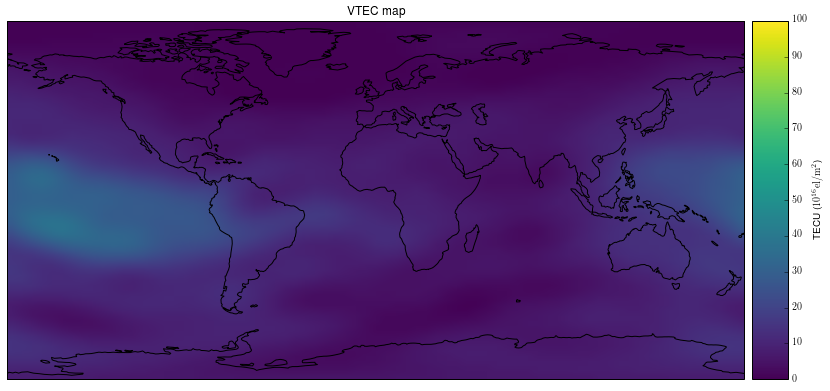

In [4]:
for tecmap in get_tecmaps(ionex_local_path(2017, 349)):
    plot_tec_map(tecmap)
    plt.show()

**Example 2**

Plot daily evolution the TEC over Madrid for all the day
s of the year 2017. The day of the year is encoded as the colour of the curve, using the inferno colormap.

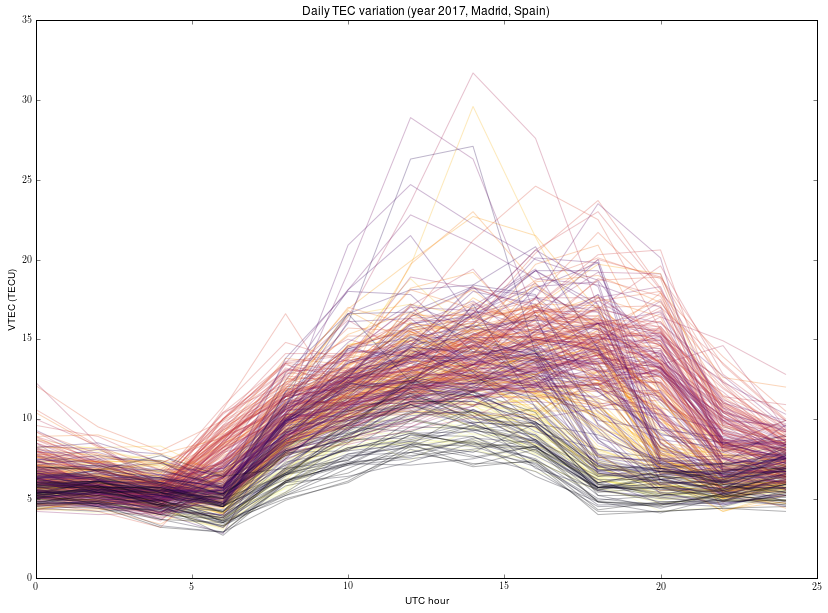

In [5]:
import matplotlib.cm
import matplotlib.colors

day_cmap = matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = 1, vmax = 365), cmap = 'inferno_r')

tecmaps = [get_tecmaps(ionex_local_path(2017, day)) for day in range(1,366)]

for day in range(1,366):
    plt.plot(np.arange(0, 26, 2), [get_tec(t, 41, -4) for t in tecmaps[day - 1]], color = day_cmap.to_rgba(day), alpha = 0.3)
plt.title('Daily TEC variation (year 2017, Madrid, Spain)')
plt.xlabel('UTC hour')
plt.ylabel('VTEC (TECU)');

The yearly evolution is seen better in the next plot, which shows the daily TEC at 12 UTC (maximum daily TEC) and 4 UTC (minimum daily TEC).

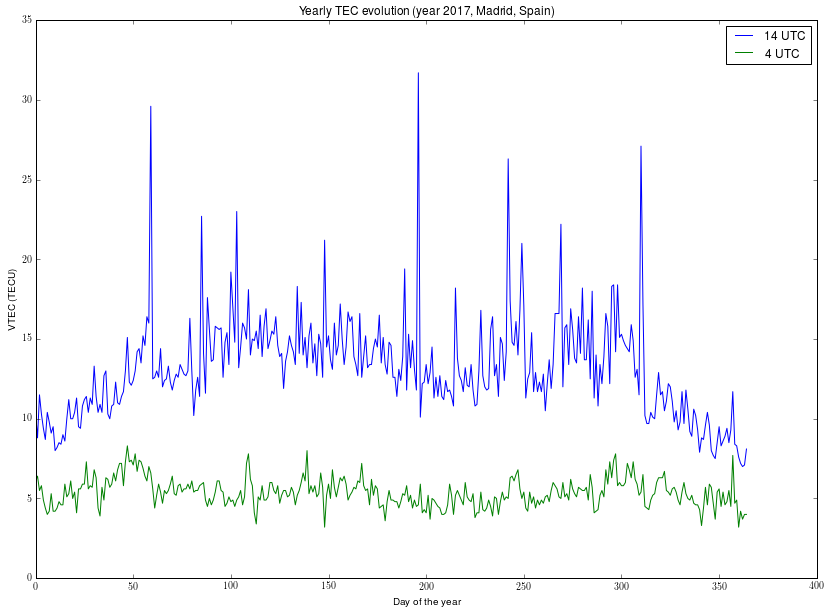

In [6]:
plt.plot([get_tec(t[7], 41, -4) for t in tecmaps])
plt.plot([get_tec(t[2], 41, -4) for t in tecmaps])
plt.title('Yearly TEC evolution (year 2017, Madrid, Spain)')
plt.legend(['14 UTC', '4 UTC'])
plt.ylabel('VTEC (TECU)')
plt.xlabel('Day of the year');

Compare this with a plot of the yearly evolution in Sydney, in the Southern hemisphere. The difference in TEC levels between summer and winter is noticeably greater in Sydney. This may be caused by the [winter anomaly](https://en.wikipedia.org/wiki/Ionosphere#Winter_anomaly).

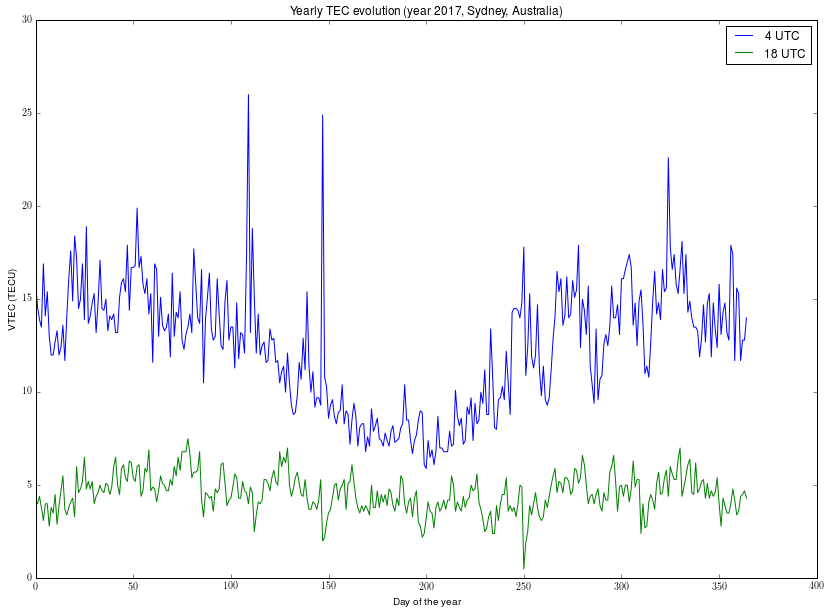

In [7]:
plt.plot([get_tec(t[2], -34, 150) for t in tecmaps])
plt.plot([get_tec(t[9], -34, 150) for t in tecmaps])
plt.title('Yearly TEC evolution (year 2017, Sydney, Australia)')
plt.legend(['4 UTC', '18 UTC'])
plt.ylabel('VTEC (TECU)')
plt.xlabel('Day of the year');

**Example 3**

Plot of daily TEC over Valladolid for the days corresponding to my [CODAR advent recording](http://destevez.net/2017/12/a-codar-advent/). The goal of this plot is to try to compare the qualitative behaviour of the CODAR reflections with the TEC level over the point of single-hop propagation between the North of Spain and my station in Madrid, especially at night.

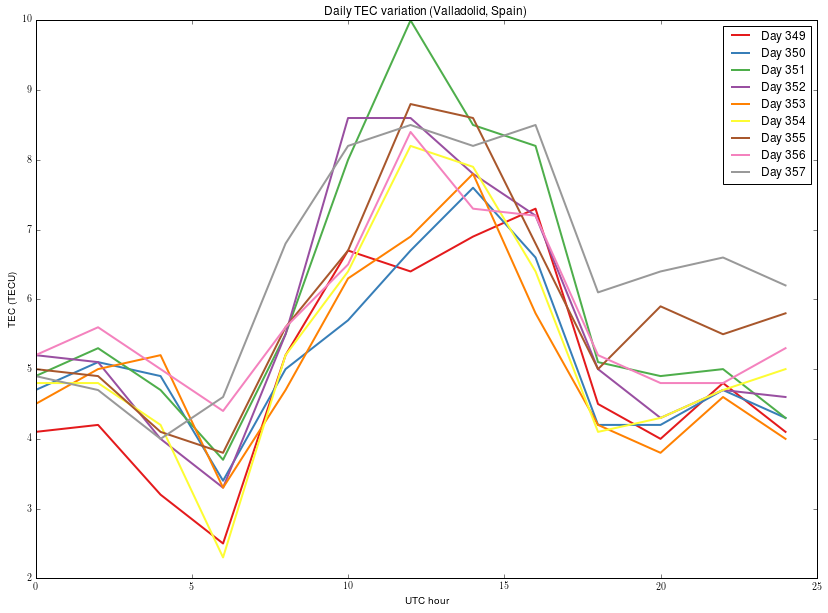

In [8]:
days = np.arange(349,358)
day_cmap = matplotlib.cm.ScalarMappable(norm = matplotlib.colors.Normalize(vmin = days[0], vmax = days[-1]), cmap = 'Set1')
for day in days:
    plt.plot(np.arange(0, 26, 2), [get_tec(t, 42, -5) for t in get_tecmaps(ionex_local_path(2017, day))], color=day_cmap.to_rgba(day), linewidth=2)
plt.legend(['Day {}'.format(day) for day in days])
plt.title('Daily TEC variation (Valladolid, Spain)')
plt.xlabel('UTC hour')
plt.ylabel('TEC (TECU)');